<a href="https://colab.research.google.com/github/Jarvisss1/Dripline-backend/blob/main/Fashion_Compatibility_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Fashion Compatibility Model using a Siamese Network (Optimized Version)
# This version includes several optimizations for speed and efficiency.

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2 # Switched to a lighter backbone
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision

import os
import zipfile
import json
import random
import numpy as np
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations
from functools import lru_cache # To cache image loading
import kagglehub # kagglehub for data

# --- 1. Configuration and Setup ---
# Define key parameters for the model and data

EPOCHS = 10
MAX_STEPS_PER_EPOCH = 1000     # Cap for faster epochs
MAX_VAL_STEPS = 200            # Cap for faster validation
BATCH_SIZE = 64                # Increased batch size

IMG_SHAPE = (128, 128, 3)      # MobileNetV2 works well with slightly larger images
DATA_DIR = 'polyvore_outfits'  # This will be updated by the download function

# --- 2. Data Acquisition ---
def download_and_extract_dataset():
    global DATA_DIR # We need to modify the global DATA_DIR variable

    # Check if the data seems to be present already to avoid re-downloading
    if os.path.exists(os.path.join('polyvore_outfits', 'polyvore_outfits_nondisjoint')):
        print("Dataset already seems to be downloaded and extracted.")
        DATA_DIR = os.path.join(os.getcwd(), 'polyvore_outfits')
        return

    print("Downloading Polyvore Outfits dataset via KaggleHub...")
    # This downloads the dataset to a cache directory and returns the path
    path = kagglehub.dataset_download("dnepozitek/polyvore-outfits")
    print(f"Dataset downloaded to: {path}")

    # The actual image data is inside a nested 'polyvore_outfits' directory
    DATA_DIR = os.path.join(path, 'polyvore_outfits')
    print(f"Updated DATA_DIR to point to images: {DATA_DIR}")

# --- 3. Data Preparation (Optimized) ---

def load_outfit_data(split='train'):
    """
    Loads the outfit data (train/valid/test) from nondisjoint folder.
    """
    DATA_ROOT = os.path.dirname(DATA_DIR)  # parent of polyvore_outfits
    path = os.path.join(DATA_ROOT, 'polyvore_outfits', 'nondisjoint', f'{split}.json')

    if not os.path.exists(path):
        raise FileNotFoundError(f"Could not find {path}. Check dataset structure.")

    with open(path, 'r') as f:
        return json.load(f)


MAX_POS_PAIRS_PER_OUTFIT = 10  # Sample at most 10 positive pairs per outfit to prevent explosion

def create_item_pairs(outfit_data):
    """
    Creates balanced positive and negative item pairs from the outfit data.
    This version limits the number of pairs per outfit to speed up processing.
    """
    all_items = [it['item_id'] for o in outfit_data for it in o['items']]
    pairs, labels = [], []

    print("Creating balanced positive and negative pairs...")
    for outfit in tqdm(outfit_data):
        items = [it['item_id'] for it in outfit['items']]
        if len(items) < 2:
            continue

        pos_pairs = list(combinations(items, 2))
        random.shuffle(pos_pairs)
        pos_pairs = pos_pairs[:MAX_POS_PAIRS_PER_OUTFIT]

        for a, b in pos_pairs:
            pairs.append([a, b])
            labels.append(1)

            neg_item = random.choice(all_items)
            while neg_item in items:
                neg_item = random.choice(all_items)
            pairs.append([a, neg_item])
            labels.append(0)

    return np.array(pairs), np.array(labels)

def preprocess_image(image_path):
    """
    Loads and preprocesses a single image.
    """
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_SHAPE[0], IMG_SHAPE[1]))
        img = np.array(img) / 255.0
        return img.astype(np.float32)
    except (IOError, UnidentifiedImageError):
        return np.zeros(IMG_SHAPE, dtype=np.float32)

@lru_cache(maxsize=10000) # Cache up to 10,000 resized images in memory
def load_and_resize(img_id):
    """Helper function to load and preprocess an image, with caching."""
    path = os.path.join(DATA_DIR, 'images', f'{img_id}.jpg')
    return preprocess_image(path)

def data_generator(pairs, labels, batch_size):
    """
    A generator to feed data to the model in batches, with caching.
    """
    num_samples = len(pairs)
    while True:
        indices = np.random.permutation(num_samples)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_pairs = pairs[batch_indices]
            batch_labels = labels[batch_indices]

            pair_images1 = [load_and_resize(p[0]) for p in batch_pairs]
            pair_images2 = [load_and_resize(p[1]) for p in batch_pairs]

            yield (np.array(pair_images1), np.array(pair_images2)), np.array(batch_labels)


# --- 4. Model Architecture (Optimized) ---
def get_siamese_base_network(input_shape):
    """
    Creates the base CNN using a lightweight MobileNetV2 backbone.
    """
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)

    return Model(inputs=base_model.input, outputs=x)

def euclidean_distance(vectors):
    """Calculates the euclidean distance between two vectors."""
    x, y = vectors
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(y_true, y_pred):
    """Contrastive loss function."""
    margin = 1
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def build_siamese_model(input_shape):
    """Builds the complete Siamese network model."""
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    base_network = get_siamese_base_network(input_shape)
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = Lambda(euclidean_distance)([processed_a, processed_b])
    model = Model([input_a, input_b], distance)
    return model



In [ ]:

download_and_extract_dataset()

print("Loading training data...")
train_outfits = load_outfit_data('train')
train_pairs, train_labels = create_item_pairs(train_outfits)

print("Loading validation data...")
valid_outfits = load_outfit_data('valid')
valid_pairs, valid_labels = create_item_pairs(valid_outfits)

train_gen = data_generator(train_pairs, train_labels, BATCH_SIZE)
valid_gen = data_generator(valid_pairs, valid_labels, BATCH_SIZE)

siamese_model = build_siamese_model(IMG_SHAPE)
siamese_model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.0001))
siamese_model.summary()

steps_per_epoch = min(len(train_pairs) // BATCH_SIZE, MAX_STEPS_PER_EPOCH)
validation_steps = min(len(valid_pairs) // BATCH_SIZE, MAX_VAL_STEPS)



Dataset downloaded to: /root/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits/versions/1
Updated DATA_DIR to point to images: /root/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits/versions/1/polyvore_outfits
Loading training data...
Creating balanced positive and negative pairs...


100%|██████████| 53306/53306 [00:02<00:00, 18643.38it/s]


Loading validation data...
Creating balanced positive and negative pairs...


100%|██████████| 5000/5000 [00:00<00:00, 60343.10it/s]


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 128)       │  2,618,816 │ input_layer_6[0]… │
│ (Functional)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_4[0][… │
│                     │                   │            │ functional_4[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,618,816 (9.99 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
print("\nStarting model training...")
history = siamese_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

base_network = siamese_model.layers[2]
base_network.save('fashion_compatibility_encoder.h5')
print("\nTraining complete. The feature encoder model saved as 'fashion_compatibility_encoder.h5'")

print("\n--- How to use the saved model for predictions ---")
print("1. Load the encoder: `encoder = tf.keras.models.load_model('fashion_compatibility_encoder.h5')`")
print(f"2. Preprocess images into the shape (1, {IMG_SHAPE[0]}, {IMG_SHAPE[1]}, 3).")
print("3. Generate embeddings: `emb1 = encoder.predict(img1)` and `emb2 = encoder.predict(img2)`")
print("4. Calculate Euclidean distance: `dist = np.linalg.norm(emb1 - emb2)`")
print("5. If `dist` is low (e.g., < 0.8), the items are likely compatible.")



Starting model training...
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2268s 2s/step - loss: 5.8430 - val_loss: 0.3107
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2237s 2s/step - loss: 0.3310 - val_loss: 0.3396
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2185s 2s/step - loss: 0.2785 - val_loss: 0.3690



Training complete. The feature encoder model saved as 'fashion_compatibility_encoder.h5'

--- How to use the saved model for predictions ---
1. Load the encoder: `encoder = tf.keras.models.load_model('fashion_compatibility_encoder.h5')`
2. Preprocess images into the shape (1, 128, 128, 3).
3. Generate embeddings: `emb1 = encoder.predict(img1)` and `emb2 = encoder.predict(img2)`
4. Calculate Euclidean distance: `dist = np.linalg.norm(emb1 - emb2)`
5. If `dist` is low (e.g., < 0.8), the items are likely compatible.


✅ Encoder model 'fashion_compatibility_encoder.h5' loaded successfully.
Found dataset at: /root/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits/versions/1
Creating test pairs...


100%|██████████| 10000/10000 [00:00<00:00, 29503.01it/s]


Generating predictions on test set...


100%|██████████| 2621/2621 [1:46:09<00:00,  2.43s/it]



--- Model Evaluation Report ---
Using distance threshold: 0.5

Overall Accuracy: 50.58%

                    precision    recall  f1-score   support

Not Compatible (0)       0.52      0.13      0.20     83871
    Compatible (1)       0.50      0.88      0.64     83871

          accuracy                           0.51    167742
         macro avg       0.51      0.51      0.42    167742
      weighted avg       0.51      0.51      0.42    167742


--- Correct Predictions ---


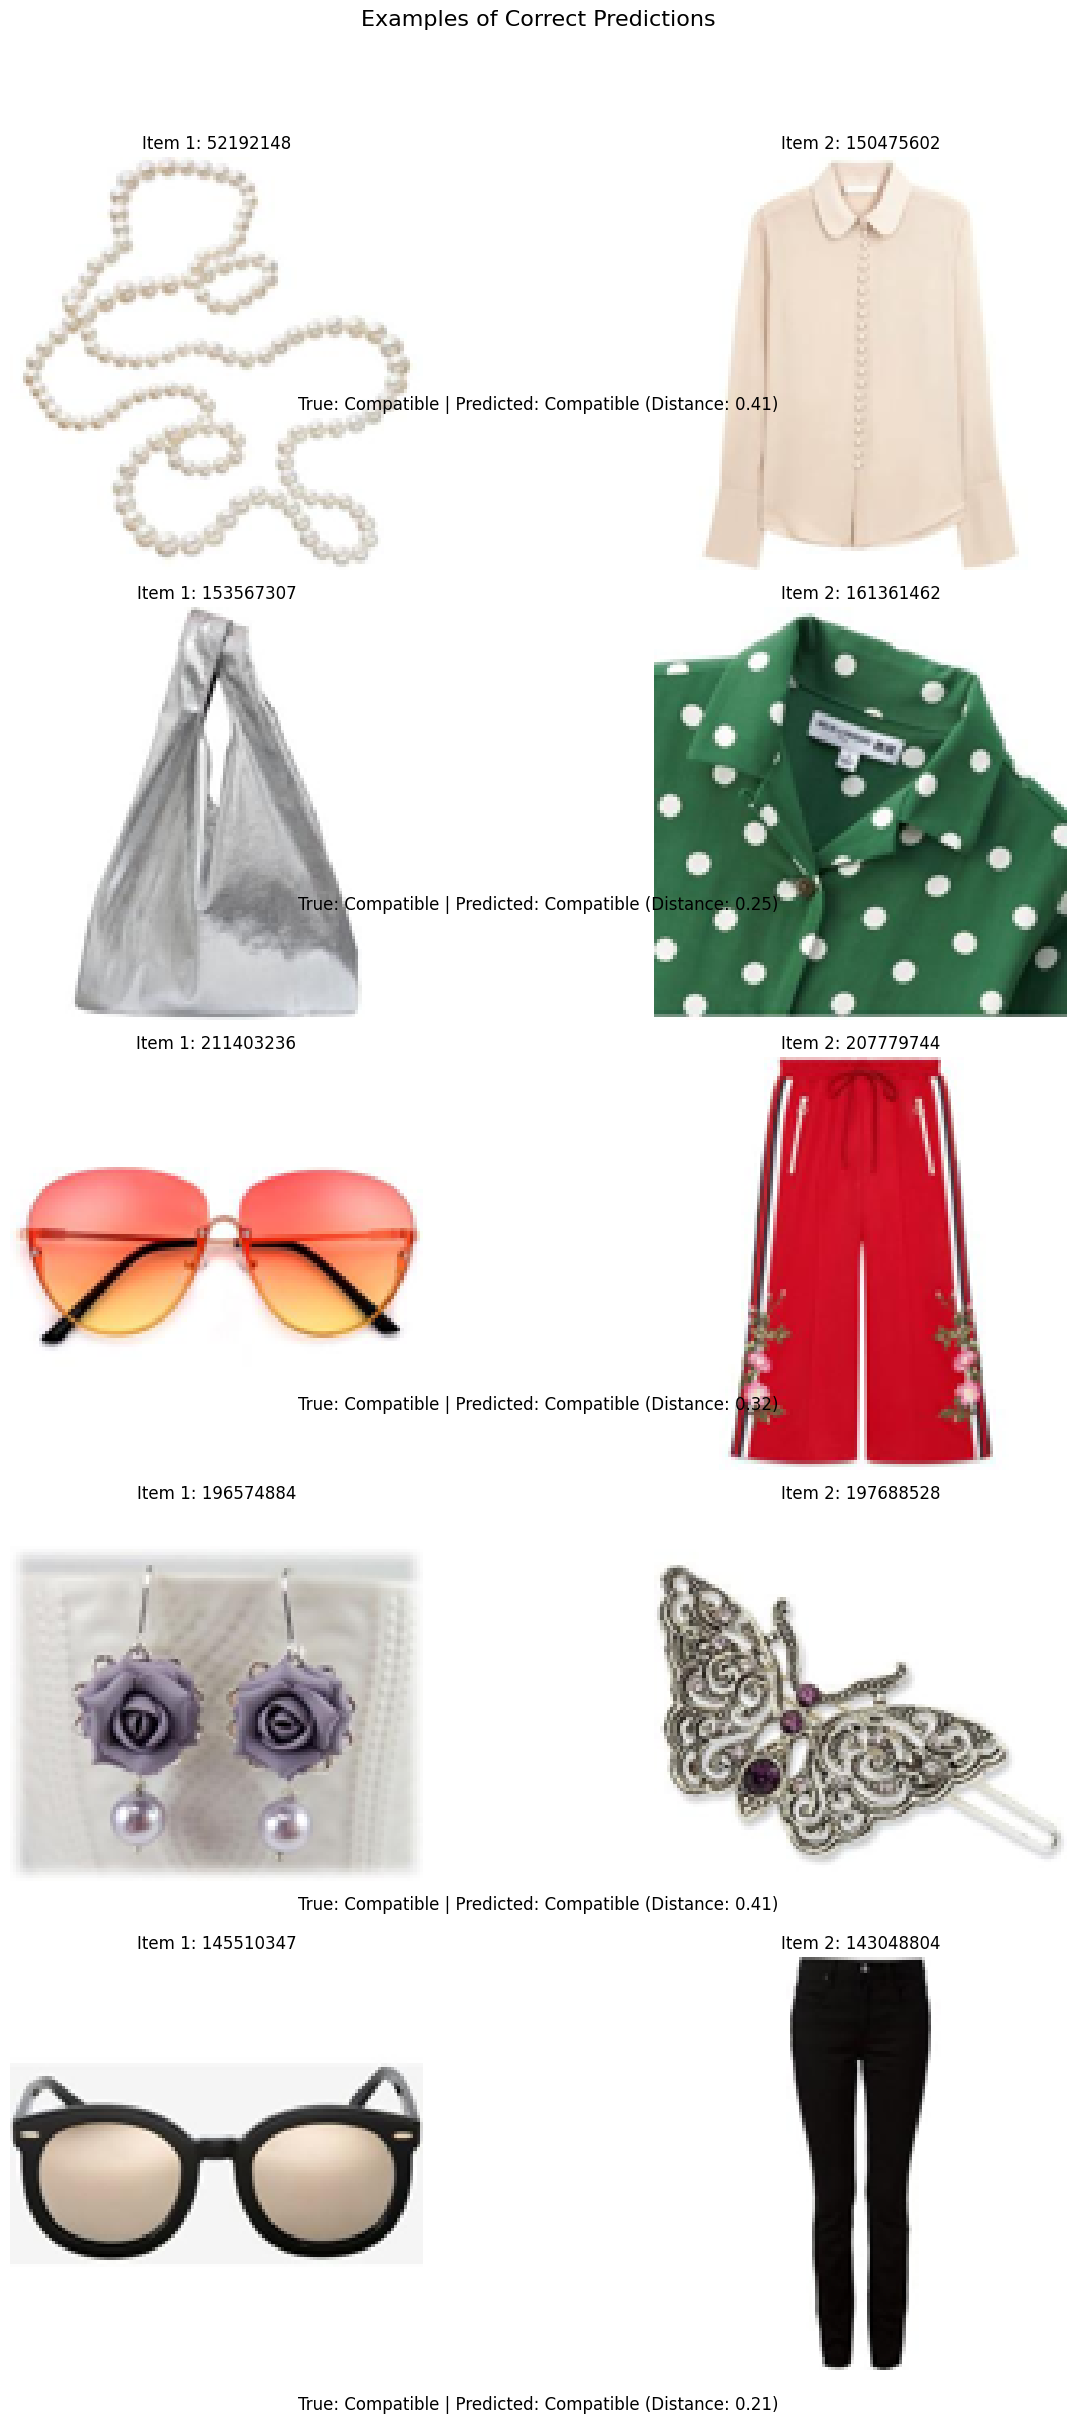


--- Incorrect Predictions ---


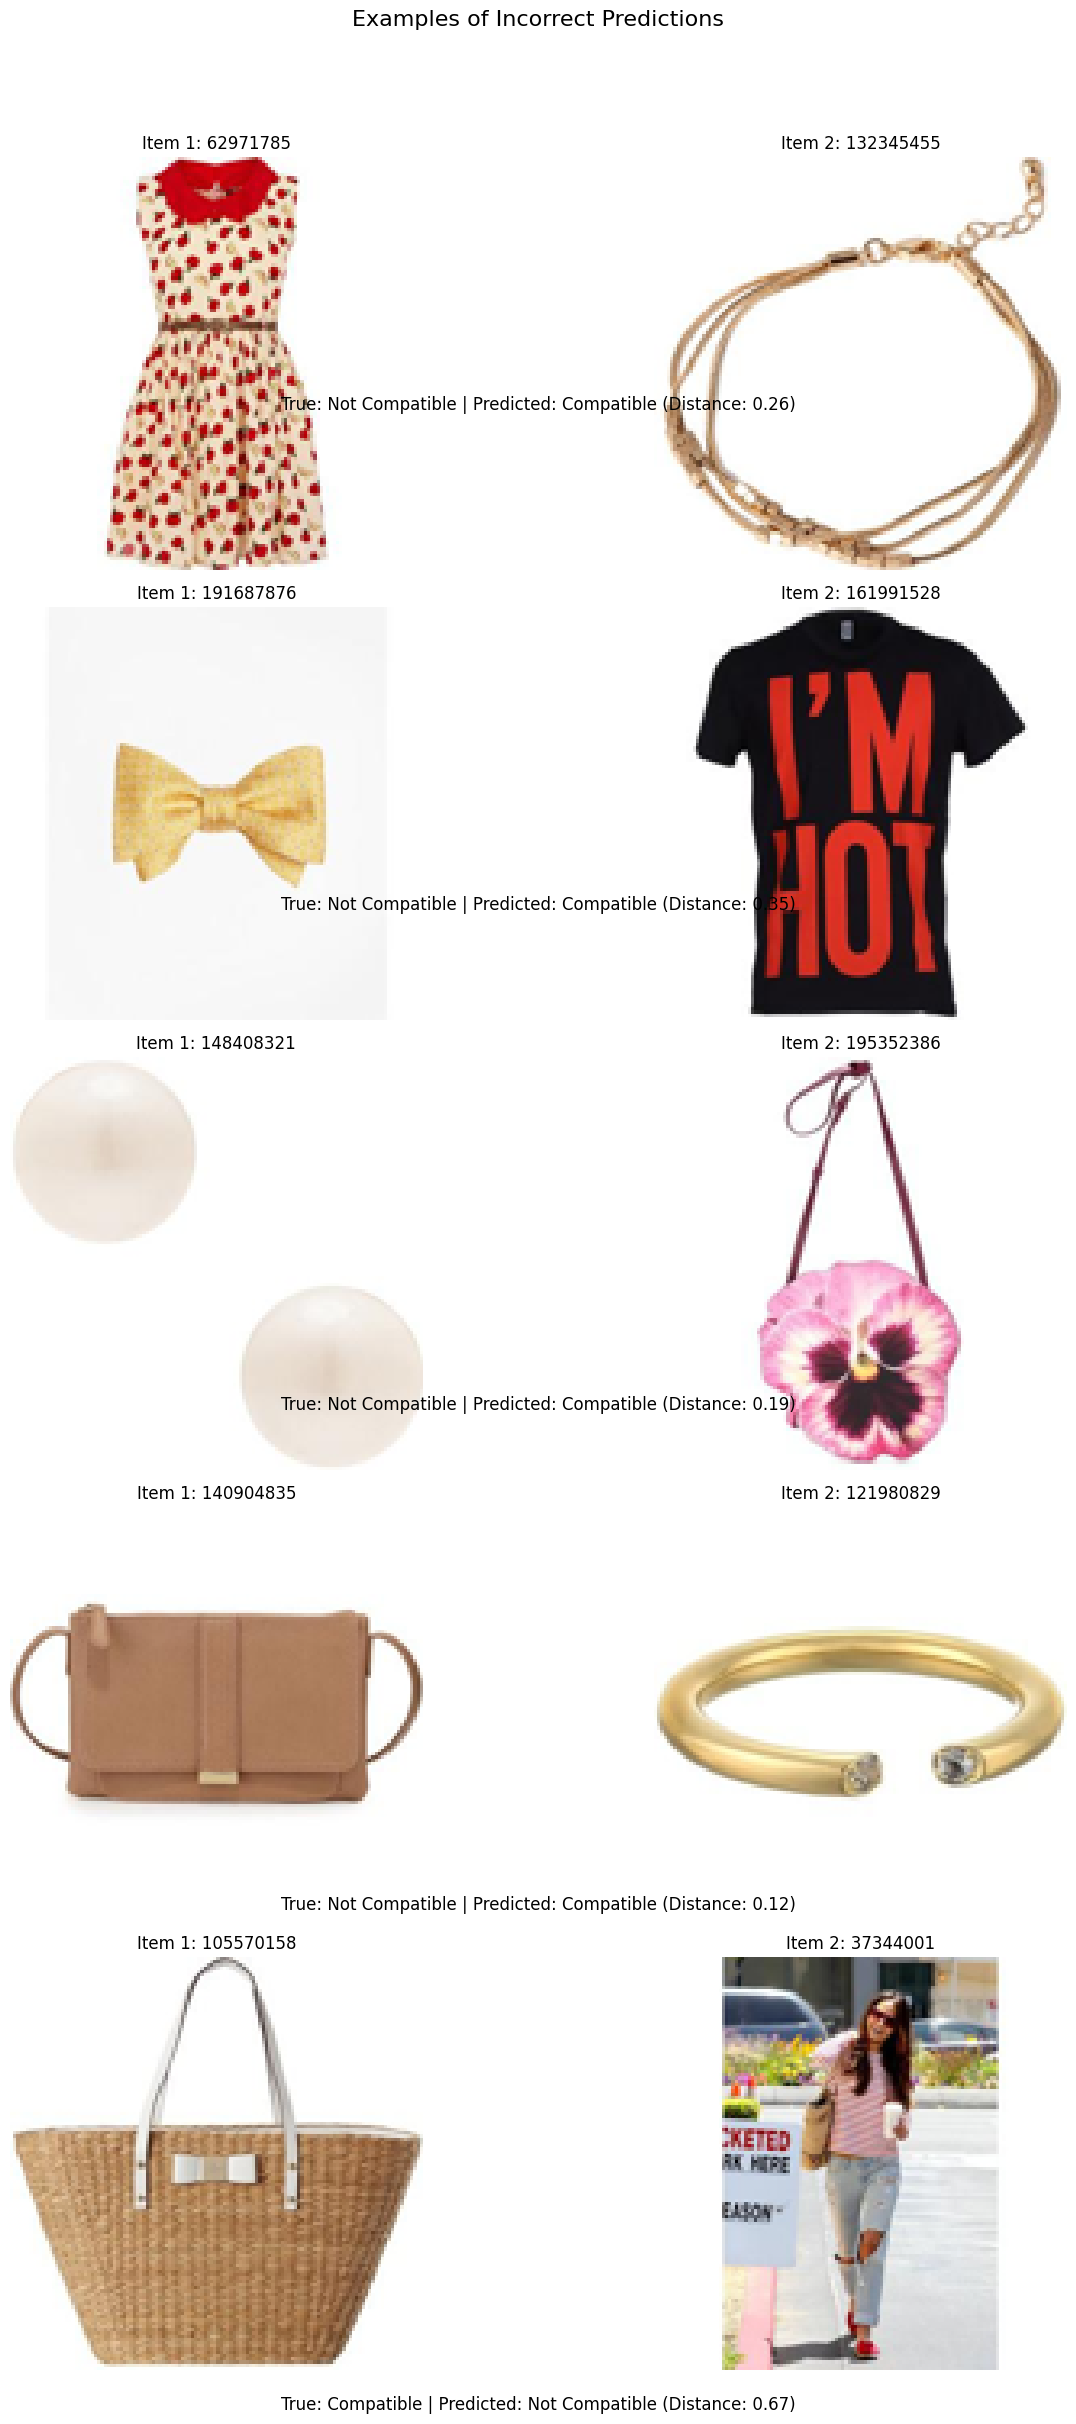

In [ ]:
# Script to evaluate the trained Fashion Compatibility Siamese Network

import tensorflow as tf
import numpy as np
import os
import json
import random
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from itertools import combinations
from functools import lru_cache
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Configuration ---
# Ensure these match the parameters used during training
IMG_SHAPE = (128, 128, 3)
BATCH_SIZE = 64
MAX_PAIRS_PER_OUTFIT = 10 # Should match the training script
PREDICTION_THRESHOLD = 0.5 # If distance is < 0.5, we predict they are compatible (label 1)

# --- 2. Data Loading and Preparation (Reusing logic from training script) ---
DATA_DIR = None
DATASET_ROOT_PATH = None

def find_dataset_path():
    """Finds the path to the downloaded Kaggle dataset."""
    global DATA_DIR, DATASET_ROOT_PATH
    # KaggleHub downloads to a standard cache directory
    # We need to find it. A common location is ~/.cache/kagglehub
    base_cache_dir = os.path.expanduser('~/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits')

    if os.path.exists(base_cache_dir):
        versions_dir = os.path.join(base_cache_dir, 'versions')
        if os.path.exists(versions_dir):
            # Find the latest version directory (e.g., '1', '2')
            versions = [d for d in os.listdir(versions_dir) if os.path.isdir(os.path.join(versions_dir, d))]
            if versions:
                latest_version = sorted(versions)[-1]
                DATASET_ROOT_PATH = os.path.join(versions_dir, latest_version)
                DATA_DIR = os.path.join(DATASET_ROOT_PATH, 'polyvore_outfits', 'images')

                # Verify that the path is correct by checking for a key file
                # CORRECTED PATH: Added 'polyvore_outfits' directory
                if os.path.exists(os.path.join(DATASET_ROOT_PATH, 'polyvore_outfits', 'nondisjoint', 'test.json')):
                    print(f"Found dataset at: {DATASET_ROOT_PATH}")
                    return True

    print("Error: Could not automatically find the downloaded Kaggle dataset.")
    print("Please ensure you have run the training script first to download the data.")
    return False

def load_outfit_data(split='test'):
    """Loads the outfit data for the specified split."""
    # CORRECTED PATH: Added 'polyvore_outfits' directory to the path
    path = os.path.join(DATASET_ROOT_PATH, 'polyvore_outfits', 'nondisjoint', f'{split}.json')
    if not os.path.exists(path):
        raise FileNotFoundError(f"Could not find {path}. Please check the dataset structure.")
    with open(path, 'r') as f:
        return json.load(f)

def create_item_pairs(outfit_data):
    """Creates balanced positive and negative item pairs."""
    all_items = [it['item_id'] for o in outfit_data for it in o['items']]
    pairs, labels = [], []
    print("Creating test pairs...")
    for outfit in tqdm(outfit_data):
        items = [it['item_id'] for it in outfit['items']]
        if len(items) < 2: continue
        pos_pairs = list(combinations(items, 2))
        random.shuffle(pos_pairs)
        pos_pairs = pos_pairs[:MAX_PAIRS_PER_OUTFIT]
        for a, b in pos_pairs:
            pairs.append([a, b]); labels.append(1)
            neg_item = random.choice(all_items)
            while neg_item in items: neg_item = random.choice(all_items)
            pairs.append([a, neg_item]); labels.append(0)
    return np.array(pairs), np.array(labels)

def preprocess_image(image_path):
    """Loads and preprocesses a single image."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_SHAPE[0], IMG_SHAPE[1]))
        img = np.array(img) / 255.0
        return img.astype(np.float32)
    except (IOError, UnidentifiedImageError):
        return np.zeros(IMG_SHAPE, dtype=np.float32)

@lru_cache(maxsize=10000)
def load_and_resize(img_id):
    """Helper function to load and preprocess an image, with caching."""
    path = os.path.join(DATA_DIR, f'{img_id}.jpg')
    return preprocess_image(path)

# --- 3. Evaluation Functions ---

def euclidean_distance(vectors):
    """Calculates the euclidean distance between two vectors for the Lambda layer."""
    x, y = vectors
    sum_square = tf.keras.backend.sum(tf.keras.backend.square(x - y), axis=1, keepdims=True)
    return tf.keras.backend.sqrt(tf.keras.backend.maximum(sum_square, tf.keras.backend.epsilon()))

def get_predictions(model, pairs):
    """Gets model predictions (distances) for all pairs."""
    predictions = []
    print("Generating predictions on test set...")

    # Build the temporary distance model ONCE outside the loop for efficiency
    input_a = tf.keras.layers.Input(shape=IMG_SHAPE, name="input_A")
    input_b = tf.keras.layers.Input(shape=IMG_SHAPE, name="input_B")
    processed_a = model(input_a)
    processed_b = model(input_b)

    # FIX: Use a Keras Lambda layer to wrap the distance calculation
    distance = tf.keras.layers.Lambda(euclidean_distance)([processed_a, processed_b])

    distance_model = tf.keras.Model([input_a, input_b], distance)

    for i in tqdm(range(0, len(pairs), BATCH_SIZE)):
        batch_pairs = pairs[i:i + BATCH_SIZE]

        pair_images1 = np.array([load_and_resize(p[0]) for p in batch_pairs])
        pair_images2 = np.array([load_and_resize(p[1]) for p in batch_pairs])

        batch_preds = distance_model.predict([pair_images1, pair_images2], verbose=0)
        predictions.extend(batch_preds.flatten())

    return np.array(predictions)

def visualize_predictions(pairs, labels, predictions, num_samples=5):
    """Shows a few example predictions."""
    correct_indices = np.where((predictions < PREDICTION_THRESHOLD) == labels)[0]
    incorrect_indices = np.where((predictions < PREDICTION_THRESHOLD) != labels)[0]

    def plot_examples(indices, title):
        if len(indices) == 0:
            print(f"No samples to show for '{title}'")
            return

        plt.figure(figsize=(15, 5 * num_samples))
        plt.suptitle(title, fontsize=16)
        sample_indices = random.sample(list(indices), min(num_samples, len(indices)))

        for i, idx in enumerate(sample_indices):
            pair = pairs[idx]
            true_label = "Compatible" if labels[idx] == 1 else "Not Compatible"
            pred_dist = predictions[idx]
            pred_label = "Compatible" if pred_dist < PREDICTION_THRESHOLD else "Not Compatible"

            img1 = load_and_resize(pair[0])
            img2 = load_and_resize(pair[1])

            ax = plt.subplot(num_samples, 2, 2 * i + 1)
            ax.imshow(img1)
            ax.axis('off')
            ax.set_title(f"Item 1: {pair[0]}")

            ax = plt.subplot(num_samples, 2, 2 * i + 2)
            ax.imshow(img2)
            ax.axis('off')
            ax.set_title(f"Item 2: {pair[1]}")

            plt.figtext(0.5, 1 - (i+0.9)/num_samples, f"True: {true_label} | Predicted: {pred_label} (Distance: {pred_dist:.2f})", ha="center", fontsize=12)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    print("\n--- Correct Predictions ---")
    plot_examples(correct_indices, "Examples of Correct Predictions")

    print("\n--- Incorrect Predictions ---")
    plot_examples(incorrect_indices, "Examples of Incorrect Predictions")


# --- 4. Main Execution ---
if __name__ == "__main__":
    # Step 1: Load the trained model
    try:
        # We add compile=False because we are not training this model, only using it for inference.
        # This prevents potential issues with custom loss functions not being found.
        encoder_model = tf.keras.models.load_model('fashion_compatibility_encoder.h5', compile=False)
        print("✅ Encoder model 'fashion_compatibility_encoder.h5' loaded successfully.")
    except IOError:
        print("❌ Error: 'fashion_compatibility_encoder.h5' not found.")
        print("Please make sure you have successfully trained and saved the model first.")
        exit()

    # Step 2: Load and prepare the test data
    if find_dataset_path():
        test_outfits = load_outfit_data('test')
        test_pairs, test_labels = create_item_pairs(test_outfits)

        # Step 3: Get predictions
        predicted_distances = get_predictions(encoder_model, test_pairs)

        # Step 4: Convert distances to binary labels
        binary_predictions = (predicted_distances < PREDICTION_THRESHOLD).astype(int)

        # Step 5: Print classification report
        print("\n--- Model Evaluation Report ---")
        print(f"Using distance threshold: {PREDICTION_THRESHOLD}\n")

        accuracy = accuracy_score(test_labels, binary_predictions)
        print(f"Overall Accuracy: {accuracy:.2%}\n")

        print(classification_report(test_labels, binary_predictions, target_names=['Not Compatible (0)', 'Compatible (1)']))

        # Step 6: Visualize some results
        visualize_predictions(test_pairs, test_labels, predicted_distances)


✅ Encoder model loaded successfully.
Found dataset at: /root/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits/versions/1
Building wardrobe database from metadata...


100%|██████████| 251008/251008 [00:02<00:00, 120009.86it/s]



Created a personal wardrobe with 100 items.

--- Testing with a new item: 170432446 (Category: shoes) ---

Finding top 5 compatible items for '170432446' within a wardrobe of 100 items.
Scoring 100 candidate items...


100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


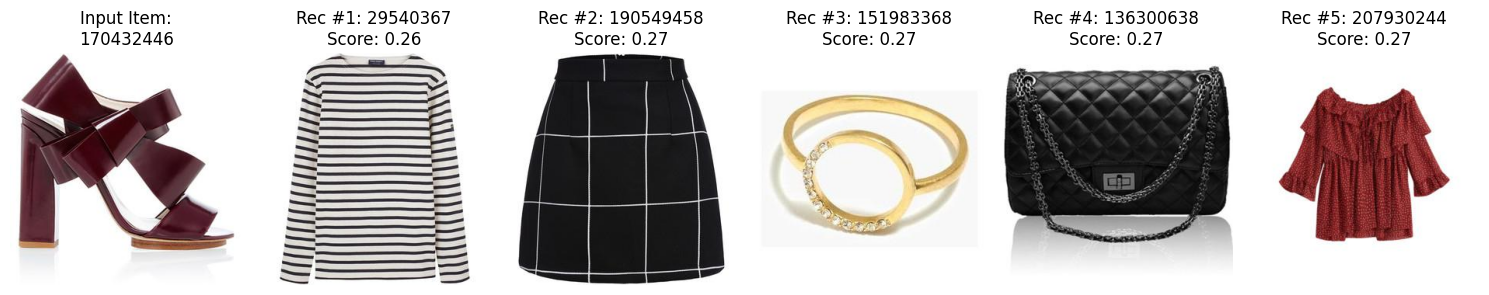

In [ ]:
# Interactive Fashion Recommender
# This script loads the trained Siamese encoder and allows you to find
# compatible items for a given piece of clothing from the dataset.

import tensorflow as tf
import numpy as np
import os
import json
import random
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from functools import lru_cache
import matplotlib.pyplot as plt

# --- 1. Configuration ---
IMG_SHAPE = (128, 128, 3)
# These global variables will be set by the find_dataset_path function
DATA_DIR = None
DATASET_ROOT_PATH = None

# --- 2. Load Model and Data ---

def find_dataset_path():
    """Finds the path to the downloaded Kaggle dataset."""
    global DATA_DIR, DATASET_ROOT_PATH
    base_cache_dir = os.path.expanduser('~/.cache/kagglehub/datasets/dnepozitek/polyvore-outfits')

    if os.path.exists(base_cache_dir):
        versions_dir = os.path.join(base_cache_dir, 'versions')
        if os.path.exists(versions_dir):
            versions = [d for d in os.listdir(versions_dir) if os.path.isdir(os.path.join(versions_dir, d))]
            if versions:
                latest_version = sorted(versions)[-1]
                DATASET_ROOT_PATH = os.path.join(versions_dir, latest_version)
                DATA_DIR = os.path.join(DATASET_ROOT_PATH, 'polyvore_outfits', 'images')

                if os.path.exists(os.path.join(DATASET_ROOT_PATH, 'polyvore_outfits', 'nondisjoint', 'test.json')):
                    print(f"Found dataset at: {DATASET_ROOT_PATH}")
                    return True
    return False

# We need metadata (category, tags) for filtering. The dataset doesn't provide rich tags,
# so we'll load the item metadata and create a simplified mock database.
WARDROBE_DB = []

def load_wardrobe_metadata():
    """Loads metadata and creates our searchable wardrobe database."""
    global WARDROBE_DB
    metadata_path = os.path.join(DATASET_ROOT_PATH, 'polyvore_outfits', 'polyvore_item_metadata.json')
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Could not find metadata at {metadata_path}")

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    print("Building wardrobe database from metadata...")
    for item_id, data in tqdm(metadata.items()):
        # Simple logic to extract tags from the description
        desc = data.get('title', '').lower() + ' ' + data.get('url_name', '').lower()
        tags = []
        if 'casual' in desc: tags.append('casual')
        if 'formal' in desc or 'work' in desc: tags.append('formal')
        if 'party' in desc or 'night' in desc: tags.append('party')
        if 'summer' in desc or 'beach' in desc: tags.append('summer')
        if 'winter' in desc or 'cold' in desc or 'sweater' in desc: tags.append('winter')

        WARDROBE_DB.append({
            'id': item_id,
            'category': data.get('semantic_category', 'unknown'),
            'tags': list(set(tags)) # Get unique tags
        })

# --- 3. Helper Functions ---

def preprocess_image(image_path):
    """Loads and preprocesses a single image."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_SHAPE[0], IMG_SHAPE[1]))
        img = np.array(img) / 255.0
        return np.expand_dims(img, axis=0) # Add batch dimension
    except (IOError, UnidentifiedImageError, FileNotFoundError):
        return np.zeros((1, *IMG_SHAPE))

@lru_cache(maxsize=None)
def get_embedding(item_id, model):
    """Computes and caches an embedding for a given item ID."""
    path = os.path.join(DATA_DIR, f'{item_id}.jpg')
    processed_img = preprocess_image(path)
    embedding = model.predict(processed_img, verbose=0)
    return embedding

def get_compatibility_score(embedding1, embedding2):
    """Calculates the euclidean distance between two embeddings."""
    return np.linalg.norm(embedding1 - embedding2)

# --- 4. Core Recommendation Logic ---

def find_compatible_items(model, input_item_id, search_space, top_n=5):
    """
    Finds the most compatible items for a given input item from a specific search space.

    Args:
        model: The loaded Keras encoder model.
        input_item_id (str): The ID of the item to find pairs for.
        search_space (list): A list of wardrobe items to search within.
        top_n (int): The number of top recommendations to return.

    Returns:
        A list of recommended items, sorted by compatibility.
    """
    print(f"\nFinding top {top_n} compatible items for '{input_item_id}' within a wardrobe of {len(search_space)} items.")

    input_embedding = get_embedding(input_item_id, model)
    if input_embedding is None:
        print("Error: Could not generate embedding for input item.")
        return []

    # Exclude the input item itself from the candidates, just in case
    candidates = [item for item in search_space if item['id'] != input_item_id]

    if not candidates:
        print("The search space is empty or only contains the input item.")
        return []

    print(f"Scoring {len(candidates)} candidate items...")
    recommendations = []
    for candidate in tqdm(candidates):
        candidate_embedding = get_embedding(candidate['id'], model)
        if candidate_embedding is not None:
            score = get_compatibility_score(input_embedding, candidate_embedding)
            recommendations.append({'item': candidate, 'score': float(score)})

    # Sort by score (ascending, lower is better) and return the top N
    recommendations.sort(key=lambda x: x['score'])
    return recommendations[:top_n]

def display_recommendations(input_item_id, recommended_items):
    """Visualizes the input item and its recommended pairs."""
    plt.figure(figsize=(15, 5))

    # Display Input Item
    ax = plt.subplot(1, len(recommended_items) + 1, 1)
    input_path = os.path.join(DATA_DIR, f'{input_item_id}.jpg')
    try:
        img = Image.open(input_path)
        ax.imshow(img)
    except FileNotFoundError:
        ax.text(0.5, 0.5, 'Image not found', ha='center')
    ax.set_title(f"Input Item:\n{input_item_id}")
    ax.axis('off')

    # Display Recommended Items
    for i, rec in enumerate(recommended_items):
        ax = plt.subplot(1, len(recommended_items) + 1, i + 2)
        item_path = os.path.join(DATA_DIR, f"{rec['item']['id']}.jpg")
        try:
            img = Image.open(item_path)
            ax.imshow(img)
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'Image not found', ha='center')
        ax.set_title(f"Rec #{i+1}: {rec['item']['id']}\nScore: {rec['score']:.2f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# --- 5. Main Execution ---
if __name__ == "__main__":
    try:
        encoder_model = tf.keras.models.load_model('fashion_compatibility_encoder.h5', compile=False)
        print("✅ Encoder model loaded successfully.")
    except IOError:
        print("❌ Error: 'fashion_compatibility_encoder.h5' not found. Please run the training script first.")
        exit()

    if find_dataset_path():
        load_wardrobe_metadata()

        if WARDROBE_DB:
            # --- Simulate a user's personal wardrobe ---
            # 1. Create a personal wardrobe of 100 items
            my_wardrobe = random.sample(WARDROBE_DB, 100)
            my_wardrobe_ids = {item['id'] for item in my_wardrobe}
            print(f"\nCreated a personal wardrobe with {len(my_wardrobe)} items.")

            # 2. Pick a new item that is NOT in the personal wardrobe
            potential_new_items = [item for item in WARDROBE_DB if item['id'] not in my_wardrobe_ids]
            if not potential_new_items:
                print("Could not find an item outside the sample wardrobe to test with.")
            else:
                new_item_to_test = random.choice(potential_new_items)
                INPUT_ITEM_ID = new_item_to_test['id']
                print(f"\n--- Testing with a new item: {INPUT_ITEM_ID} (Category: {new_item_to_test['category']}) ---")

                # 3. Find compatible items for the new item from WITHIN the personal wardrobe
                recommendations = find_compatible_items(
                    model=encoder_model,
                    input_item_id=INPUT_ITEM_ID,
                    search_space=my_wardrobe, # IMPORTANT: We search only in the user's wardrobe
                    top_n=5
                )

                if recommendations:
                    display_recommendations(INPUT_ITEM_ID, recommendations)
                else:
                    print("Could not find any compatible items in the personal wardrobe.")
        else:
            print("Full wardrobe is empty. Cannot run recommendation.")


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras /content/fashion_compatibility_encoder.h5 /content/models/

2025-08-30 20:05:07.589739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756584307.654455    1412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756584307.673550    1412 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756584307.701954    1412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756584307.702019    1412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756584307.702029    1412 computation_placer.cc:177] computation placer alr